In [1]:
"""
This contains the basic models for the simulation of a steady-state ethylene reactor.

© 2023. Triad National Security, LLC. All rights reserved.
This program was produced under U.S. Government contract 89233218CNA000001 for Los Alamos
National Laboratory (LANL), which is operated by Triad National Security, LLC for the U.S.
Department of Energy/National Nuclear Security Administration. All rights in the program are.
reserved by Triad National Security, LLC, and the U.S. Department of Energy/National Nuclear
Security Administration. The Government is granted for itself and others acting on its behalf a
nonexclusive, paid-up, irrevocable worldwide license in this material to reproduce, prepare.
derivative works, distribute copies to the public, perform publicly and display publicly, and to permit.
others to do so.

@author: Sean T. Smith, 1 Nov. 2022
"""
from numpy import array, empty, linspace, pi as π

%matplotlib inline
import matplotlib.pyplot as plt

from parameter_set import ParameterSet, get_default_params, set_default_params
from reactor_modeling import (thermo_c_ideal, spec_names, spec_molar_masses, mix_molar_mass,
                              rxn_rate_Klugherz, rxn_rate_alt, calc_spec_rates, pore_eff_thiele1,
                              cat_geom_sphere, cat_geom_cylinder, trans_Re, trans_Pr, trans_Sc,
                              turb_Nu_text, turb_Nu_finlayson, turb_Nu_Kramers,
                              film_flux_x, rxr_plugflow_x)
from _reactor import (rxn_rate_combo, diff_bin_fuller, diff_mix, diff_pore_knudsen, diff_mix_wpores,
                      pore_eff_thiele0, cat_geom_annularcylinder, turb_Nu_Gnielinski,
                      turb_Nu_Li, turb_Nu_Peters, film_flux_xT, rxr_plugflow_xT)

In [2]:
# Test rate laws at Klugherz's standard conditions:
T_expt = 220 + 273.15  # temperature in the experiment [C converted to K]
P_expt = 1.32 * 1.01325e5  # pressure in the experiment [atm converted to Pa]
x_expt = array([0.263, 0.263, 0, 0, 0, 0]) / 1.32
x_expt[-1] = 1 - x_expt[:-1].sum()

# Klugherz's own rate law:
PSS1a = type('ParameterSetSubclass1a', (ParameterSet,), dict())
θ_Klug = PSS1a(rate_params=get_default_params(rxn_rate_Klugherz))
R0 = rxn_rate_Klugherz(x_expt, P_expt, T_expt, **set_default_params(rxn_rate_Klugherz, θ_Klug))
print(R0 * 0.5 * 60 / array([1.141, 1.104]))
spec_rates, heating = calc_spec_rates(x_expt, P_expt, T_expt, rxn_rate_Klugherz,
                                      **set_default_params(rxn_rate_Klugherz, θ_Klug))
print(spec_rates)
print(' ')

# Alternate rate law:
PSS1b = type('ParameterSetSubclass1b', (ParameterSet,), dict())
θ_alt = PSS1b(rate_params=get_default_params(rxn_rate_alt))
R0 = rxn_rate_alt(x_expt, P_expt, T_expt, **set_default_params(rxn_rate_alt, θ_alt))
print(R0 * 0.5 * 60)  # convert to mol-rxn / (min. g-cat)
spec_rates, heating = calc_spec_rates(x_expt, P_expt, T_expt, rxn_rate_alt,
                                      **set_default_params(rxn_rate_alt, θ_alt))
print(spec_rates)
print(heating)
print(' ')

# Combination rate law:
PSS1c = type('ParameterSetSubclass1c', (ParameterSet,), dict())
θ_combo = PSS1c(rate_params=get_default_params(rxn_rate_combo))
R0 = rxn_rate_combo(x_expt, P_expt, T_expt, **set_default_params(rxn_rate_combo, θ_combo))
print(R0 * 0.5 * 60)  # convert to mol-rxn / (min. g-cat)
spec_rates, heating = calc_spec_rates(x_expt, P_expt, T_expt, rxn_rate_combo,
                                      **set_default_params(rxn_rate_combo, θ_combo))
print(spec_rates)
print(heating)
print(' ')

[6.49976471e-06 4.99994384e-06]
[-4.31205651e-07 -6.75597659e-07  2.47207718e-07  3.67995867e-07
  3.67995867e-07  0.00000000e+00]
 
[6.58150464e-06 5.04247126e-06]
[-3.87465863e-07 -6.13938870e-07  2.19383488e-07  3.36164750e-07
  3.36164750e-07  0.00000000e+00]
-0.24578120054714175
 
[6.58185925e-06 5.04180462e-06 0.00000000e+00]
[-3.87455463e-07 -6.13878116e-07  2.19395308e-07  3.36120308e-07
  3.36120308e-07  0.00000000e+00]
-0.24575306325332405
 


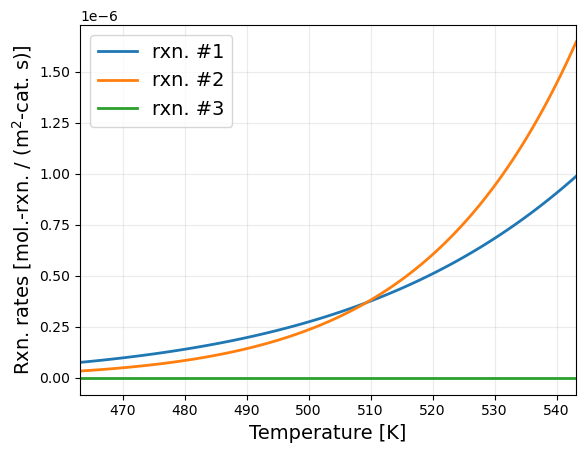

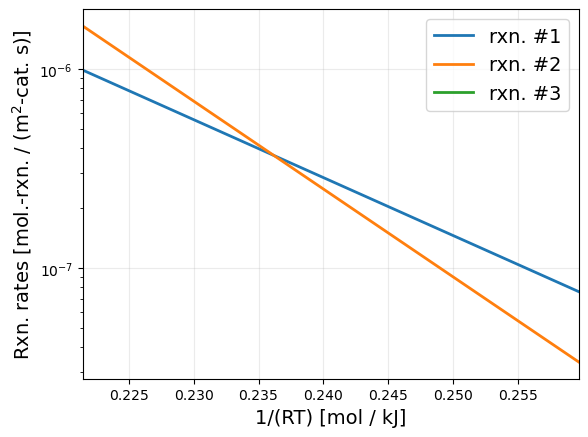

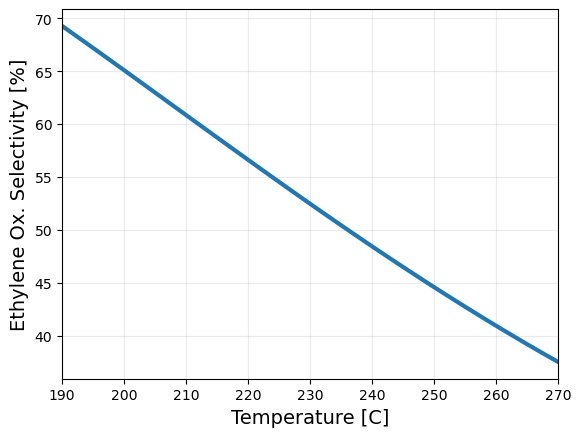

In [3]:
R_gas = get_default_params(thermo_c_ideal)['R']  # Gas constant [J / (mol K)]
n = 100
T_test = linspace(190, 270, n) + 273.15
R_test = empty((n, 3))
for i in range(n):
    R_test[i] = rxn_rate_combo(x_expt, P_expt, T_test[i],
                               **set_default_params(rxn_rate_combo, θ_combo))
plt.plot(T_test, R_test, linewidth=2)
plt.xlim(T_test[0], T_test[-1])
plt.xlabel('Temperature [K]', fontsize=14)
plt.ylabel('Rxn. rates [mol.-rxn. / (m$^2$-cat. s)]', fontsize=14)
plt.legend(['rxn. #1', 'rxn. #2', 'rxn. #3'], fontsize=14)
plt.grid(True, alpha=0.25)
plt.figure()
plt.semilogy(1e3 / (R_gas * T_test), R_test, linewidth=2)
plt.xlim(1e3 / (R_gas * T_test[-1]), 1e3 / (R_gas * T_test[0]))
plt.xlabel('1/(RT) [mol / kJ]', fontsize=14)
plt.ylabel('Rxn. rates [mol.-rxn. / (m$^2$-cat. s)]', fontsize=14)
plt.legend(['rxn. #1', 'rxn. #2', 'rxn. #3'], fontsize=14)
plt.grid(True, alpha=0.25)
plt.figure()
plt.plot(T_test - 273.15, 100 * R_test[:, 0] / (R_test[:, 0] + R_test[:, 1]), linewidth=3)
plt.xlim(T_test[0] - 273.15, T_test[-1] - 273.15)
plt.xlabel('Temperature [C]', fontsize=14)
plt.ylabel('Ethylene Ox. Selectivity [%]', fontsize=14)
plt.grid(True, alpha=0.25);

In [4]:
# Dij = diff_bin_fuller(P=(2 * 101.325e3), T=(240 + 273.15), M=spec_molar_masses())
Dij = diff_bin_fuller(P=(1 * 101.325e3), T=(35 + 273.15), M=spec_molar_masses())
print(Dij.max(), Dij.min())
print(Dij[-1])
# Dmix = diff_mix(Dij, x_expt)
Dmix = diff_mix(Dij, array([0, 0.21, 0, 0, 0, 0.79]))
print(Dmix)
# D = array([2.0e-5, 2.6e-5, 1.7e-5, 2.1e-5, 3.3e-5, 2.4e-5])

3.3959142612496056e-05 9.247086697521266e-06
[1.62940894e-05 2.18453556e-05 1.39824506e-05 1.72542616e-05
 2.73446322e-05 2.16354744e-05]
[1.63079908e-05 2.18453556e-05 1.39698232e-05 1.72530431e-05
 2.74544440e-05 2.18453556e-05]


In [5]:
θ_cat=dict(ρ_cat = 881,  # catalyst density [kg / m^3]
           a_cat = 0.8e3,  # catalyst surface area (including pores) per mass [m^2/kg]
           ε_void = 0.75,  # as-packed void fraction (gaps-between pellets) [-]
           D_pore = 4e-6,  # diameter of the pores [m]
           # D_pore = 40e-9,  # diameter of the pores [m]
           L_pore = 1e-3)  # characteristic pore length [m]

In [6]:
R = get_default_params(thermo_c_ideal)['R']  # gas constant [m^3 Pa/(K mol)] = [m^2 kg/(s^2 K mol)]
Ctot = thermo_c_ideal(P_expt, T_expt, R)
θ_diff = get_default_params(diff_bin_fuller)
M = spec_molar_masses()  # molar masses [g/mol]
V_mol = θ_diff['V_mol']  # diffusion volumes
α_fuller = θ_diff['α_fuller']  # constant in the Fuller equation [?]
Dij = diff_bin_fuller(P_expt, T_expt, M, α_fuller, V_mol)
# print(f'{Dij = }')
# Dmix = diff_mix(Dij, x_expt)
# print(f'{Dmix = }')
Dk = diff_pore_knudsen(T_expt, θ_cat['D_pore'], R, M)
# print(f'{Dk = }')
Dmix = diff_mix_wpores(Dij, Dk, x_expt)
# print(f'{Dmix = }')

# Constant
print('Constant approximation:')
ε_pore = pore_eff_thiele0(θ_cat['D_pore'], θ_cat['L_pore'], Dmix, x_expt, P_expt, T_expt, Ctot,
                          rxn_rate_Klugherz, **set_default_params(rxn_rate_Klugherz, θ_Klug))
print('  Klug:', ε_pore)
ε_pore = pore_eff_thiele0(θ_cat['D_pore'], θ_cat['L_pore'], Dmix, x_expt, P_expt, T_expt, Ctot,
                          rxn_rate_alt, **set_default_params(rxn_rate_alt, θ_alt))
print('  alt:', ε_pore)
ε_pore = pore_eff_thiele0(θ_cat['D_pore'], θ_cat['L_pore'], Dmix, x_expt, P_expt, T_expt, Ctot,
                          rxn_rate_combo, **set_default_params(rxn_rate_combo, θ_combo))
print('  combo:', ε_pore)
print(' ')

# Linearized - single reactant
print('Linear (independent) approximation:')
ε_pore = pore_eff_thiele1(θ_cat['D_pore'], θ_cat['L_pore'], Dmix, x_expt, P_expt, T_expt, Ctot,
                          rxn_rate_Klugherz, **set_default_params(rxn_rate_Klugherz, θ_Klug))
print('  Klug:', ε_pore)
ε_pore = pore_eff_thiele1(θ_cat['D_pore'], θ_cat['L_pore'], Dmix, x_expt, P_expt, T_expt, Ctot,
                          rxn_rate_alt, **set_default_params(rxn_rate_alt, θ_alt))
print('  alt:', ε_pore)
ε_pore = pore_eff_thiele1(θ_cat['D_pore'], θ_cat['L_pore'], Dmix, x_expt, P_expt, T_expt, Ctot,
                          rxn_rate_combo, **set_default_params(rxn_rate_combo, θ_combo))
print('  combo:', ε_pore)
print(' ')

# # Linearized — coupled
# print('Linear (coupled) approximation:')
# ε_pore = pore_eff_thieleL(θ_cat['D_pore'], θ_cat['L_pore'], Dmix, x_expt, P_expt, T_expt, Ctot,
#                           rxn_rate_Klugherz, **set_default_params(rxn_rate_Klugherz, θ_Klug))
# print('  Klug:', ε_pore)
# ε_pore = pore_eff_thieleL(θ_cat['D_pore'], θ_cat['L_pore'], Dmix, x_expt, P_expt, T_expt, Ctot,
#                           rxn_rate_alt, **set_default_params(rxn_rate_alt, θ_alt))
# print('  alt:', ε_pore)
# ε_pore = pore_eff_thieleL(θ_cat['D_pore'], θ_cat['L_pore'], Dmix, x_expt, P_expt, T_expt, Ctot,
#                           rxn_rate_combo, **set_default_params(rxn_rate_combo, θ_combo))
# print('  combo:', ε_pore)

Constant approximation:
  Klug: [1. 1.]
  alt: [1. 1.]
  combo: [1. 1. 1.]
 
Linear (independent) approximation:
  Klug: [0.99942604 0.99957273]
  alt: [0.99949061 0.99960967]
  combo: [0.99949058 0.99960972 0.99999923]
 


/Users/smith_sean/Documents/ConglomerateUQ/ToyProblem-EthyleneOx/_reactor.py:165: RuntimeWarning: divide by zero encountered in true_divide
  z_crit_all = where(-M > x, L_pore * (1 - sqrt((x + M) / M)), L_pore)
/Users/smith_sean/Documents/ConglomerateUQ/ToyProblem-EthyleneOx/_reactor.py:165: RuntimeWarning: invalid value encountered in sqrt
  z_crit_all = where(-M > x, L_pore * (1 - sqrt((x + M) / M)), L_pore)


In [7]:
θ_cat_geom_sphere = dict(D_pellet = 2e-2)  # pellet diameter [m]
θ_cat_geom_cylinder = dict(H_pellet = 2e-2,  # pellet height [m]
                           D_pellet = 2e-2)  # pellet diameter [m]
θ_cat_geom_annularcylinder = dict(H_pellet = 2e-2,  # pellet height [m]
                                  Do_pellet = 2e-2,  # pellet outer diameter [m]
                                  Di_pellet = 1e-2)  # pellet inner diameter [m]

In [8]:
print('Sphere:')
print('  ', cat_geom_sphere(*θ_cat_geom_sphere.values()))
print('Cylinder:')
print('  ', cat_geom_cylinder(*θ_cat_geom_cylinder.values()))
print('Annular Cylinder:')
print('  ', cat_geom_annularcylinder(*θ_cat_geom_annularcylinder.values()))

Sphere:
   (300.0, 0.02)
Cylinder:
   (300.0, 0.022894284851066645)
Annular Cylinder:
   (500.0, 0.020800838230519047)


In [9]:
Re = 80
Pr = 3
ε = 0.75
print(turb_Nu_finlayson(Re, Pr, ε))
print(turb_Nu_Kramers(Re, Pr, ε))
print(turb_Nu_Gnielinski(Re, Pr, ε))

7.45439579301876
12.54273207087818
19.271647186373542


In [10]:
# # Model for the mass-transfer flux through the film (at the catalyst surface):
# def film_flux_Nx(Xrxr, u, rxn_rate_law, pore_eff, turb_Nu, θ, Ctot, guess):
#     """
#     Solve for the species fluxes through the mass-transfer film to the surface of the catalyst.
#     """
#     # Explicitly unpack the more important parameters from θ:
#     P, T, R, ν_visc = θ.thermo
#     n_spec = int(θ.n_spec)
#     M = θ.M
#     n_rxn = int(θ.n_rxn)

#     Dij = diff_bin(P, T, M, θ.α_fuller, θ.V_mol)
    
#     # Pellet geometery:
#     A2V, _ = geom_sphere(θ.L_pellet)  # surface-area-to-volume ratio (assumes spherical pellets)
#     # Pore surface area over film area:
#     Ap2Af = θ.ρ_cat * θ.a_cat / A2V  # [-] 

#     # Mass transfer through film & pore reaction/diffusion (as a residual):
#     def rxn_diff(unknowns, xδ, u, rxn_rate_law, pore_eff, turb_Nu, θ, Ctot, Dij):
#         """Calculate a residual for the fluxes across the film."""
#         # Explicitly unpack the more important parameters from θ:
#         ν_rxn = θ.ν_rxn.reshape((n_spec, n_rxn))
#         # Unpack the unknowns:
#         N = empty(n_spec)
#         N[:-1] = unknowns[:(n_spec - 1)]
#         N[-1] = -(M[:-1] * N[:-1]).sum() / M[-1]
#         x0 = empty(n_spec)
#         x0[:-1] = unknowns[(n_spec - 1):]
#         x0[-1] = 1 - x0[:-1].sum()

#         # Calculations:
#         xbar = (x0 + xδ) / 2  # mid-value mole fractions [-]
#         Dk = diff_knudsen(T0, θ.D_pore, R, M)
#         Dmix = diff_mix_wpores(Dij, Dk, x0)
#         Re = trans_Re(u, θ.L_pellet, ν_visc)
#         Sc = trans_Sc(ν_visc, Dmix)
#         Sh = turb_Nu(Re, Sc, θ.ε_void, *θ.turb_bed)
#         k_diff = (Sh * Dmix) / θ.L_pellet
#         rxn_rate = rxn_rate_law(x0, P, T, *θ.rate_params)
#         ε_pore = pore_eff(θ.D_pore, θ.L_pore, Dmix, x0, P, T, Ctot, rxn_rate_law, ν_rxn, θ.rate_params)
#         rate_eff = ε_pore * rxn_rate

#         # Residuals
#         resid = empty(2 * (n_spec - 1))
#         resid[:(n_spec - 1)] = N[:-1] - Ctot * k_diff[:-1] * (x0[:-1] - xδ[:-1])
#         resid[(n_spec - 1):] = N[:-1] - Ap2Af * (ν_rxn @ rate_eff)[:-1]
#         resid *= 1e4  # scale the molar flux residuals to ~unity
#         return resid

#     unknowns = fsolve(rxn_diff, guess,
#                       args=(Xrxr, u, rxn_rate_law, pore_eff, turb_Nu, θ, Ctot, Dij))
#     Ni = empty(n_spec)
#     Ni[:-1] = unknowns[:(n_spec - 1)]
#     Ni[-1] = -(M[:-1] * Ni[:-1]).sum() / M[-1]
#     return Ni

# def film_flux_all(X, T, u, rxn_rate_law, pore_eff, turb_Nu, θ, Ctot, guess):
#     """
#     Solve for the species fluxes through the mass-transfer film to the surface of the catalyst.
#     """
#     # Explicitly unpack the more important parameters from θ:
#     P, R, ν_visc = θ.thermo
#     n_spec = int(θ.n_spec)
#     M = θ.M
#     n_rxn = int(θ.n_rxn)

#     # Species binary diffusion coefficients:
#     Dij = diff_bin(P, T, M, θ.α_fuller, θ.V_mol)
#     # Pellet outer surface area to volume ratio & sphere-equivalent diameter:
#     A2V, Dse = geom_annularcylinder(θ.Do_pellet, θ.Di_pellet, θ.H_pellet)
#     # Pore total surface area over film area:
#     Ap2Af = θ.ρ_cat * θ.a_cat / A2V  # [-] 

#     # Mass transfer through film & pore reaction/diffusion (as a residual):
#     def rxn_diff(unknowns, xδ, Tδ, u, rxn_rate_law, pore_eff, turb_Nu, θ, Ctot, Dij):
#         """Calculate a residual for the fluxes across the film."""
        
#         # Explicitly unpack the more important parameters from θ:
#         ν_rxn = θ.ν_rxn.reshape((n_spec, n_rxn))
#         # Unpack the unknowns:
#         N = empty(n_spec)
#         N[:-1] = unknowns[:(n_spec - 1)]
#         N[-1] = -(M[:-1] * N[:-1]).sum() / M[-1]
#         x0 = empty(n_spec)
#         x0[:-1] = unknowns[(n_spec - 1):-2]
#         x0[-1] = 1 - x0[:-1].sum()
#         q = unknowns[-2]
#         T0 = unknowns[-1]

#         # Setup:
#         # TODO: recalculate Ctot & Dij at mid & 0?
#         xbar = (x0 + xδ) / 2  # mid-value mole fractions [-]
#         Re = trans_Re(u, Dse, ν_visc)
#         Sc_ij = trans_Sc(ν_visc, Dij)
#         Sh_ij = turb_Nu(Re, Sc_ij, θ.ε_void, *θ.turb_bed)
#         k_ij = (Sh_ij * Dij) / Dse
#         Pr = trans_Pr(ν_visc, k_conduct / (Ctot * (xbar @ Cp)))
#         Nu = turb_Nu(Re, Pr, θ.ε_void, *θ.turb_bed)
#         h = (Nu * k_conduct / Dse)

#         rxn_rate = rxn_rate_law(x0, P, T0, *θ.rate_params)
#         Dk = diff_knudsen(T0, θ.D_pore, R, M)
#         Dmix = diff_mix_wpores(Dij, Dk, x0)
#         ε_pore = pore_eff(θ.D_pore, θ.L_pore, Dmix, x0, P, T0, Ctot,
#                           rxn_rate_law, ν_rxn, θ.rate_params)
#         rate_eff = ε_pore * rxn_rate

#         # Residuals:
#         resid = empty(2 * (n_spec - 1) + 2)
#         resid[:(n_spec - 1)] = (((outer(xbar, N) - outer(N, xbar)) / k_ij).sum(axis=1)
#                                 - Ctot * (x0 - xδ))[:-1]
#         resid[(n_spec - 1):-2] = N[:-1] - Ap2Af * (ν_rxn @ rate_eff)[:-1]
#         resid[:-2] *= 1e4  # scale the molar flux residuals to ~unity
#         resid[-2] = q - Ap2Af * (-θ.ΔH_rxn @ rate_eff)
#         resid[-1] = q - h * (T0 - Tδ)
#         resid[-2:] *= 1e-3  # scale the heat flux residuals to ~unity
#         return resid
#     # return rxn_diff(guess, X, T, u, rxn_rate_law, pore_eff, turb_Nu, θ, Ctot, Dij)
    
#     unknowns = fsolve(rxn_diff, guess,
#                       args=(X, T, u, rxn_rate_law, pore_eff, turb_Nu, θ, Ctot, Dij))
#     Ni = empty(n_spec)
#     Ni[:-1] = unknowns[:(n_spec - 1)]
#     Ni[-1] = -(M[:-1] * Ni[:-1]).sum() / M[-1]
#     x0 = empty(n_spec)
#     x0[:-1] = unknowns[(n_spec - 1):-2]
#     x0[-1] = 1 - x0[:-1].sum()
#     T0 = unknowns[-1]
#     q = unknowns[-2]
#     return Ni, x0, q, T0

# def film_flux_rxn(X, T, u, rxn_rate_law, pore_eff, turb_Nu, θ, Ctot, guess):
#     """
#     Solve for the species fluxes through the mass-transfer film to the surface of the catalyst.
#     """
#     # Explicitly unpack the more important parameters from θ:
#     P, R, ν_visc = θ.thermo
#     n_spec = int(θ.n_spec)
#     M = θ.M
#     n_rxn = int(θ.n_rxn)

#     # Species binary diffusion coefficients:
#     Dij = diff_bin(P, T, M, θ.α_fuller, θ.V_mol)
#     # Pellet outer surface area to volume ratio & sphere-equivalent diameter:
#     A2V, Dse = geom_annularcylinder(θ.Do_pellet, θ.Di_pellet, θ.H_pellet)
#     # Pore total surface area over film area:
#     Ap2Af = θ.ρ_cat * θ.a_cat / A2V  # [-]
    
#     # # Testing: no film, only reaction...
#     # ν_rxn = θ.ν_rxn.reshape((n_spec, n_rxn))
#     # # rxn_rate = rxn_rate_law(X, P, T, *θ.rate_params)
#     # rxn_rate = rxn_rate_law(X, P, 220 + 273.15, *θ.rate_params)
#     # N = empty(n_spec)
#     # N[:-1] = Ap2Af * (ν_rxn @ rxn_rate)[:-1]
#     # N[-1] = -(M[:-1] * N[:-1]).sum() / M[-1]
#     # q = Ap2Af * (-θ.ΔH_rxn @ rxn_rate)  # heat flux per film area
#     # return N, X, q, T, rxn_rate, ones(n_rxn), ones(n_rxn)

#     # Mass transfer through film & pore reaction/diffusion (as a residual):
#     def rxn_diff(rxn_rate, xδ, Tδ, u, rxn_rate_law, pore_eff, turb_Nu, θ, Ctot, Dij, residual=True):
#         """Calculate a residual for the fluxes across the film."""
#         # Explicitly unpack the more important parameters from θ:
#         ν_rxn = θ.ν_rxn.reshape((n_spec, n_rxn))

#         # Solve for intermediate unknowns:
#         # TODO: recalculate properties at mid & 0?
#         N = empty(n_spec)
#         N[:-1] = Ap2Af * (ν_rxn @ rxn_rate)[:-1]
#         N[-1] = -(M[:-1] * N[:-1]).sum() / M[-1]

#         Re = trans_Re(u, Dse, ν_visc)
#         Sc_ij = trans_Sc(ν_visc, Dij)
        
#         Sh_ij = turb_Nu(Re, Sc_ij, θ.ε_void, *θ.turb_bed)
#         k_ij = (Sh_ij * Dij) / Dse
#         A = -(1 / k_ij) * N.reshape((n_spec, 1))
#         A.reshape(-1)[::n_spec + 1] += (1 / k_ij) @ N / 2 + Ctot
#         b = Ctot * xδ + (((1 / k_ij) @ xδ) * N - ((1 / k_ij) @ N) * xδ) / 2
#         A[-1] = 1
#         b[-1] = 1  # x0[-1] = 1 - x0[:-1].sum()
#         x0 = solve(A, b)

#         Pr = trans_Pr(ν_visc, k_conduct / (Ctot * (xδ @ Cp)))
#         Nu = turb_Nu(Re, Pr, θ.ε_void, *θ.turb_bed)
#         h = (Nu * k_conduct / Dse)
#         q = Ap2Af * (-θ.ΔH_rxn @ rxn_rate)  # heat flux per film area
#         T0 = Tδ + q / h

#         rxn_rate0 = rxn_rate_law(x0, P, T0, *θ.rate_params)
#         # rxn_rate0 = rxn_rate_law(x0, P, Tδ, *θ.rate_params)  # for debugging
#         Dk = diff_knudsen(T0, θ.D_pore, R, M)
#         Dmix = diff_mix_wpores(Dij, Dk, x0)
#         ε_pore = pore_eff(θ.D_pore, θ.L_pore, Dmix, x0, P, T0, Ctot,
#                           ν_rxn, θ.ΔH_rxn, rxn_rate_law, θ.rate_params)
#         if residual:
#             # Residuals:
#             resid = rxn_rate - ε_pore * rxn_rate0
#             # resid *= 1e7  # scale the rate to ~unity (currently scaled in the solver)
#             return resid
#         else:
#             return N, x0, q, T0, ε_pore
#     # # Testing:
#     # return rxn_diff(guess, X, T, u, rxn_rate_law, pore_eff, turb_Nu, θ, Ctot, Dij)  # for testing
    
#     rxn_rate = fsolve(rxn_diff, guess, args=(X, T, u, rxn_rate_law, pore_eff, turb_Nu, θ, Ctot, Dij))
#     res = least_squares(rxn_diff, guess, bounds=(0, +inf),
#                         x_scale=(1e-7 * ones(n_rxn)),
#                         xtol=1e-4, max_nfev=5000,
#                         args=(X, T, u, rxn_rate_law, pore_eff, turb_Nu, θ, Ctot, Dij))
#     if not res.success:
#         print(res)
#     rxn_rate = res.x
#     res = rxn_diff(rxn_rate, X, T, u, rxn_rate_law, pore_eff, turb_Nu, θ, Ctot, Dij, False)
#     N, x0, q, T0, ε_pore = res
    
#     rxn_rateδ = rxn_rate_law(X, P, T, *θ.rate_params)
#     ε_film = rxn_rate / (ε_pore * rxn_rateδ)
#     return N, x0, q, T0, rxn_rate, ε_film, ε_pore

In [11]:
# Submodel selection:
rxn_rate = rxn_rate_Klugherz
pore_eff = pore_eff_thiele1
turb_Nu = turb_Nu_text

# Parameter values:
PSS2a = type('ParameterSetSubclass2a', (ParameterSet,), dict())
θ = PSS2a(# Thermodynamic properties:
          thermo=dict(P=P_expt,  # pressure [Pa]
                      T=T_expt,  # Temperature [K]
                      **get_default_params(thermo_c_ideal)),
          # Chemical species properties:
          spec=dict(**get_default_params(spec_molar_masses),
                    D = array([2.0e-5, 2.6e-5, 1.7e-5, 2.1e-5, 3.3e-5, 2.4e-5]),  # diff. coefs.
                    μ_visc=2.6e-5),  # viscosity [Pa s = kg / (s m)]
          # Chemical reaction properties & parameters:
          rxn=get_default_params(rxn_rate),
          # Turbulence parameters:
          turb_bed=get_default_params(turb_Nu),
          # Catalyst properties:
          cat=θ_cat)
Ctot = thermo_c_ideal(*θ.thermo)
A2V, Dse = cat_geom_sphere(*θ_cat_geom_sphere.values())
n_dot = array([80.5, 91.5, 0, 0, 0, 1274])  # molar feed rates — industrial reactor [kmol/hr]
n_dot *= 1e3 / (60 * 60)  # convert to [mol/s]
x_in = n_dot / n_dot.sum()  # reactor-inlet mole fractions [-]
Q_in = n_dot.sum() / Ctot  # volumetric feed rates — industrial reactor [m^3/s]
A_tube = π * 1.956e-2**2  # single-reactor-tube cross-sectional area [m^2]
n_tubes = 2781  # number of tubes — industrial reactor [-]
u_in = Q_in / (n_tubes * A_tube)  # superficial velocity [m/s]

guess = x_in[:-1].copy()  # initial guess — surface mole fractions [-]
res = film_flux_x(x_in, u_in, rxn_rate, pore_eff,
                  turb_Nu, θ, Ctot, A2V, Dse, guess)
N, x0, rxn_rate, ε_film, ε_pore = res

print('N =', N)
# print('spec_rate:', Ap2Af * (ν_rxn @ rxn_rate))
print('x0=', x0)
# print(rxn_rate)
# print(ε_film, ε_pore)

N = [-2.40008382e-04 -4.36033709e-04  1.13596574e-04  2.52823616e-04
  2.52823616e-04 -2.19672310e-12]
x0= [0.05317585 0.0594526  0.00133475 0.00258019 0.00190877 0.88154785]


In [12]:
# species molar heat capacities [J / (kg K)] (C2H4, O2, C2H4O, CO2, H2O, N2)
Cp = array([2160, 970, 1630, 1020, 1950, 1050])

# Submodel selection:
rxn_rate = rxn_rate_combo
diff_bin_coeffs = diff_bin_fuller
pore_eff = pore_eff_thiele1
turb_Nu = turb_Nu_Gnielinski

# Parameter values:
PSS2c = type('ParameterSetSubclass2c', (ParameterSet,), dict())
θ = PSS2c(# Thermodynamic properties:
          thermo=dict(P=P_expt,  # pressure [Pa]
                      R=get_default_params(thermo_c_ideal)['R']),  # gas constant
          # Chemical species properties:
          spec=dict(**get_default_params(spec_molar_masses),
                    heat_cap=Cp,
                    diff_bin_coeffs=get_default_params(diff_bin_coeffs),
                    k_conduct=0.041,  # thermal conductivity of the gas [W / (m K)]
                    μ_visc=2.6e-5),  # viscosity [Pa s = kg / (s m)]
          # Chemical reaction properties & parameters:
          rxn=get_default_params(rxn_rate),
          # Turbulence parameters:
          turb_bed=get_default_params(turb_Nu),
          # Catalyst properties:
          cat=θ_cat)

Ctot = thermo_c_ideal(θ.P, T_expt, θ.R)
A2V, Dse = cat_geom_annularcylinder(*θ_cat_geom_annularcylinder.values())
n_dot = array([80.5, 91.5, 0, 0, 0, 1274])  # molar feed rates — industrial reactor [kmol/hr]
n_dot *= 1e3 / (60 * 60)  # convert to [mol/s]
x_in = n_dot / n_dot.sum()  # reactor-inlet mole fractions [-]
Q_in = n_dot.sum() / Ctot  # volumetric feed rates — industrial reactor [m^3/s]
A_tube = π * 1.956e-2**2  # single-reactor-tube cross-sectional area [m^2]
n_tubes = 2781  # number of tubes — industrial reactor [-]
u_in = Q_in / (n_tubes * A_tube)  # superficial velocity [m/s]

x0 = x_in  # initial guess — surface mole fractions [-]
guess = array([*x0[:-1], T_expt])
res = film_flux_xT(x_in, T_expt, u_in, rxn_rate, diff_bin_coeffs, pore_eff,
                   turb_Nu, θ, Ctot, A2V, Dse, guess)
N, x0, q, T0, rxn_rate, ε_film, ε_pore = res

print('N =', N)
# print('spec_rate:', Ap2Af * (ν_rxn @ rxn_rate))
print('x0=', x0)
# print(q, T0, T0 - T_expt)
# print(rxn_rate)
# print(ε_film, ε_pore)

N = [-1.63084318e-04 -2.92759991e-04  7.89695564e-05  1.71139176e-04
  1.70974224e-04 -5.27207754e-06]
x0= [5.42819348e-02 6.12309858e-02 7.58729720e-04 1.42247247e-03
 1.03040865e-03 8.81275469e-01]


/Users/smith_sean/Documents/ConglomerateUQ/ToyProblem-EthyleneOx/_reactor.py:358: RuntimeWarning: divide by zero encountered in true_divide
  ε_film = rxn_rate / (ε_pore * rxn_rateδ)


inlet superficial velocity = 0.08 m/s


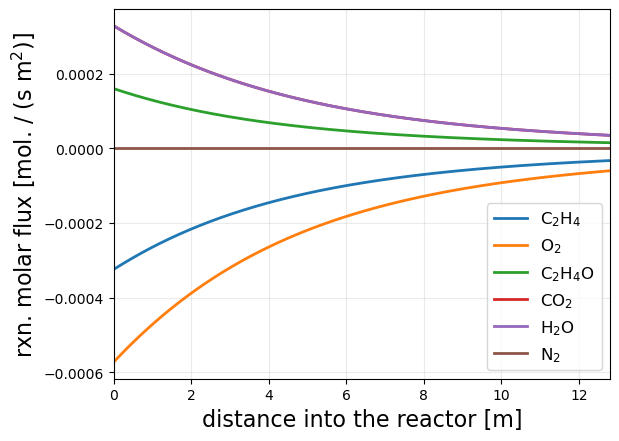

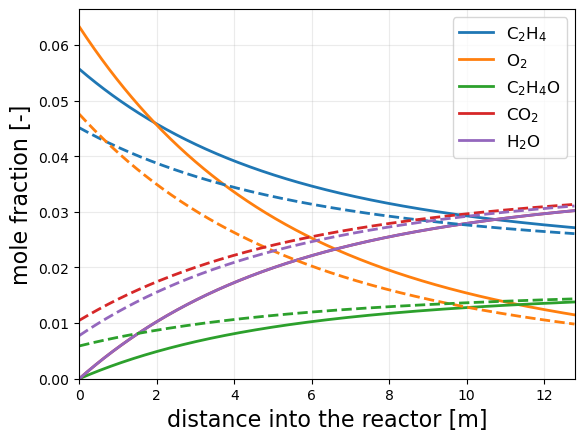

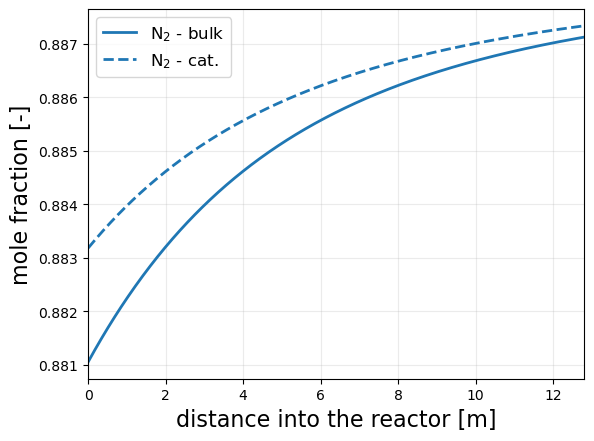

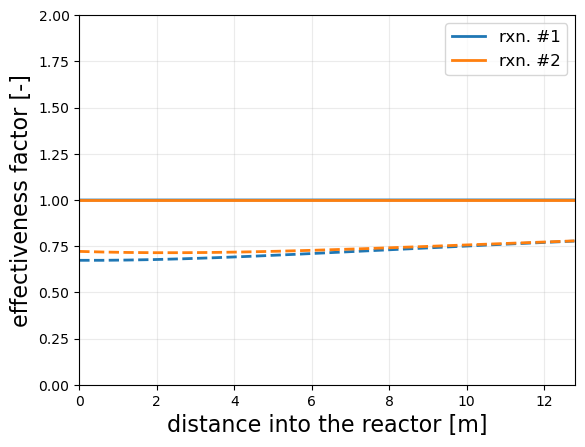

In [13]:
# Submodel selections:
thermo_c = thermo_c_ideal
rxn_rate = rxn_rate_Klugherz
pore_eff = pore_eff_thiele1
cat_geom = cat_geom_sphere
θ_cat['cat_geom'] = θ_cat_geom_sphere
turb_Nu = turb_Nu_text

# Parameter values:
PSS3a= type('ParameterSetSubclass3a', (ParameterSet,), dict())
θ = PSS3a(# Thermodynamic properties:
          thermo=dict(P=(2 * 101.325e3),  # pressure [Pa]
                      T=(200 + 273.15),  # Temperature [K]
                      **get_default_params(thermo_c_ideal)),
          # Chemical species properties:
          spec=dict(**get_default_params(spec_molar_masses),
                    D = array([2.0e-5, 2.6e-5, 1.7e-5, 2.1e-5, 3.3e-5, 2.4e-5]),  # diff. coefs.
                    μ_visc=2.6e-5),  # viscosity [Pa s = kg / (s m)]
          # Chemical reaction properties & parameters:
          rxn=get_default_params(rxn_rate),
          # Turbulence parameters:
          turb_bed=get_default_params(turb_Nu),
          # Catalyst properties:
          cat=θ_cat,
          # Reactor properties & operation:
          rxr=dict(l_reactor=12.8,  # reactor length [m]
                   # l_reactor=2.0,  # reactor length [m]
                   r_reactor=1.956e-2))

# Operational calculations:
Ctot = thermo_c(*θ.thermo)
n_dot = array([80.5, 91.5, 0, 0, 0, 1274]) / 30  # molar feed rates — industrial reactor [kmol/hr]
# n_dot = array([80.5, 91.5, 0, 0, 0, 1274]) / 5  # molar feed rates — industrial reactor [kmol/hr]
n_dot *= 1e3 / (60 * 60)  # convert to [mol/s]
x_in = n_dot / n_dot.sum()  # reactor-inlet mole fractions [-]
Q_in = n_dot.sum() / Ctot  # volumetric feed rates — industrial reactor [m^3/s]
A_tube = π * θ.r_reactor**2  # single-reactor-tube cross-sectional area [m^2]
n_tubes = 2781  # number of tubes — industrial reactor [-]
u_in = Q_in / (n_tubes * A_tube)  # superficial velocity [m/s]
print(f'inlet superficial velocity = {u_in:.2f} m/s')

# Run the coupled model:
n_z = 600
out = rxr_plugflow_x(x_in, u_in, thermo_c, rxn_rate, pore_eff, cat_geom, turb_Nu, θ, n_z)
Zrxr, Nrxr, Xrxr, Ncat, Xcat, ε_film, ε_pore = out

# Plot the results:
plt.figure()
plt.plot(Zrxr[:-1], Ncat[:-1], linestyle='-', linewidth=2.0)
plt.gca().set_prop_cycle(None)
# plt.plot(Zrxr[1:], Xcat[1:, :-1], linestyle='--', linewidth=2.0)
plt.grid(True, alpha=0.25)
plt.xlim(Zrxr[0], Zrxr[-1])
# plt.ylim(0, None)
plt.xlabel('distance into the reactor [m]', fontsize=16)
plt.ylabel('rxn. molar flux [mol. / (s m$^2$)]', fontsize=16)
plt.legend(spec_names, fontsize=12)

plt.figure()
plt.plot(Zrxr, Xrxr[:, :-1], linestyle='-', linewidth=2.0)
plt.gca().set_prop_cycle(None)
plt.plot(Zrxr[:-1], Xcat[:-1, :-1], linestyle='--', linewidth=2.0)
plt.grid(True, alpha=0.25)
plt.xlim(Zrxr[0], Zrxr[-1])
plt.ylim(0, None)
plt.xlabel('distance into the reactor [m]', fontsize=16)
plt.ylabel('mole fraction [-]', fontsize=16)
plt.legend(spec_names[:-1], fontsize=12)

plt.figure()
plt.plot(Zrxr, Xrxr[:, -1], linestyle='-', linewidth=2.0, label='N$_2$ - bulk')
plt.gca().set_prop_cycle(None)
plt.plot(Zrxr[:-1], Xcat[:-1, -1], linestyle='--', linewidth=2.0, label='N$_2$ - cat.')
plt.grid(True, alpha=0.25)
plt.xlim(Zrxr[0], Zrxr[-1])
# plt.ylim(0, None)
plt.xlabel('distance into the reactor [m]', fontsize=16)
plt.ylabel('mole fraction [-]', fontsize=16)
plt.legend(fontsize=12)

plt.figure()
plt.plot(Zrxr[:-1], ε_pore[:-1], linestyle='-', linewidth=2.0)
plt.gca().set_prop_cycle(None)
plt.plot(Zrxr[:-1], ε_film[:-1], linestyle='--', linewidth=2.0)
plt.grid(True, alpha=0.25)
plt.xlim(Zrxr[0], Zrxr[-1])
plt.ylim(0, 2)
plt.xlabel('distance into the reactor [m]', fontsize=16)
plt.ylabel('effectiveness factor [-]', fontsize=16)
plt.legend([f'rxn. #{i + 1}' for i in range(rxn_rate.n_rxn)], fontsize=12) ;

inlet superficial velocity = 0.08 m/s


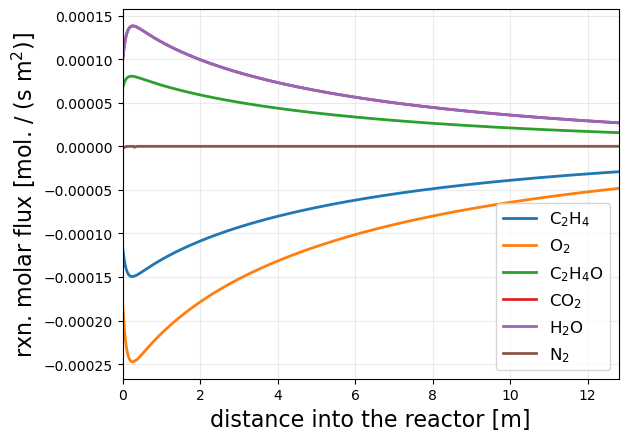

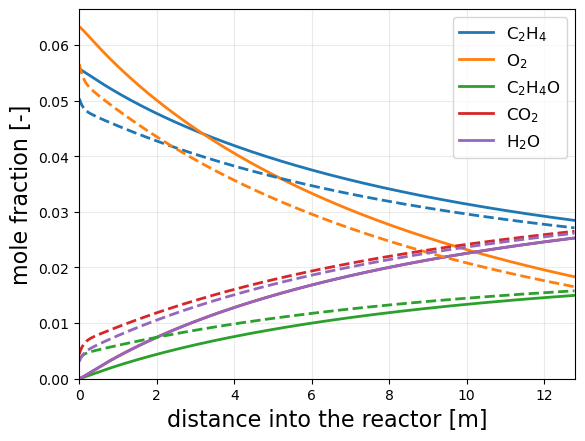

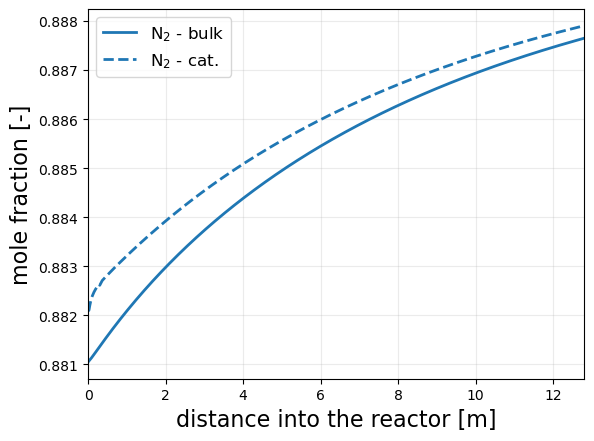

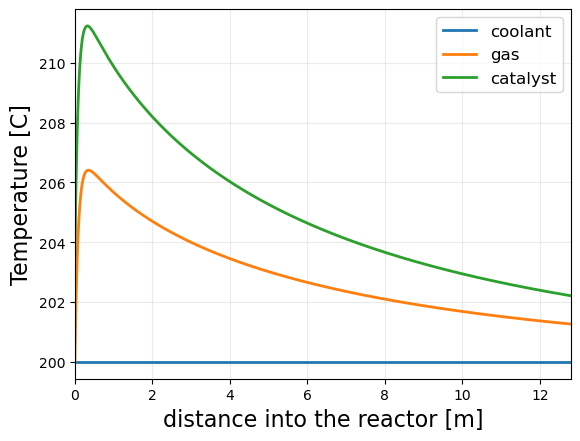

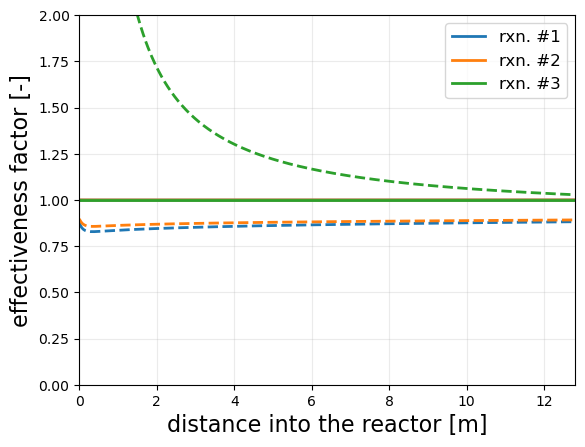

In [14]:
# species molar heat capacities [J / (kg K)] (C2H4, O2, C2H4O, CO2, H2O, N2)
Cp = array([2160, 970, 1630, 1020, 1950, 1050])

# Submodel selection:
thermo_c = thermo_c_ideal
rxn_rate = rxn_rate_combo
diff_bin_coeffs = diff_bin_fuller
pore_eff = pore_eff_thiele1
cat_geom = cat_geom_annularcylinder
θ_cat['cat_geom'] = θ_cat_geom_annularcylinder
turb_Nu_bed = turb_Nu_Gnielinski
turb_Nu_wall = turb_Nu_Li

# Parameter values:
PSS3c= type('ParameterSetSubclass3c', (ParameterSet,), dict())
θ = PSS3c(# Thermodynamic properties:
          thermo=dict(P=(2 * 101.325e3),  # pressure [Pa]
                      R=get_default_params(thermo_c)['R']),  # gas constant
          # Chemical species & transport properties:
          spec=dict(**get_default_params(spec_molar_masses),
                    heat_cap=Cp,  # species heat capacities
                    diff_bin_coeffs=get_default_params(diff_bin_coeffs),
                    k_conduct=0.041,  # thermal conductivity of the gas [W / (m K)]
                    μ_visc=2.6e-5),  # viscosity [Pa s = kg / (s m)]
          # Chemical reaction properties & parameters:
          rxn=get_default_params(rxn_rate),
          # Turbulence parameters:
          turb_bed=get_default_params(turb_Nu_bed),
          turb_wall=get_default_params(turb_Nu_wall),
          # Catalyst properties:
          cat=θ_cat,
          # Reactor properties & operation:
          rxr=dict(l_reactor=12.8,  # reactor length [m]
                   # l_reactor=2.0,  # reactor length [m]
                   r_reactor=1.956e-2,  # reactor radius [m]
                   T_cool=(200 + 273.15)))  # temperature of the cooling fluid for the reactor [K]

T_in = 200 + 273.15  # temperature [K]
Ctot = thermo_c(θ.P, T_in, θ.R)

# Operational calculations:
n_dot = array([80.5, 91.5, 0, 0, 0, 1274]) / 30  # molar feed rates — industrial reactor [kmol/hr]
# n_dot = array([80.5, 91.5, 0, 0, 0, 1274]) / 5  # molar feed rates — industrial reactor [kmol/hr]
n_dot *= 1e3 / (60 * 60)  # convert to [mol/s]
x_in = n_dot / n_dot.sum()  # reactor-inlet mole fractions [-]
Q_in = n_dot.sum() / Ctot  # volumetric feed rates — industrial reactor [m^3/s]
A_tube = π * θ.r_reactor**2  # single-reactor-tube cross-sectional area [m^2]
n_tubes = 2781  # number of tubes — industrial reactor [-]
u_in = Q_in / (n_tubes * A_tube)  # superficial velocity [m/s]
print(f'inlet superficial velocity = {u_in:.2f} m/s')

# Run the coupled model:
n_z = 600
out = rxr_plugflow_xT(x_in, T_in, u_in, thermo_c, rxn_rate, diff_bin_coeffs, pore_eff,
                      cat_geom, turb_Nu_bed, turb_Nu_wall, θ, n_z)
Zrxr, Nrxr, Xrxr, Trxr, Ncat, Xcat, Tcat, ε_film, ε_pore = out

# Plot the results:
plt.figure()
plt.plot(Zrxr[:-1], Ncat[:-1], linestyle='-', linewidth=2.0)
plt.gca().set_prop_cycle(None)
# plt.plot(Zrxr[1:], Xcat[1:, :-1], linestyle='--', linewidth=2.0)
plt.grid(True, alpha=0.25)
plt.xlim(Zrxr[0], Zrxr[-1])
# plt.ylim(0, None)
plt.xlabel('distance into the reactor [m]', fontsize=16)
plt.ylabel('rxn. molar flux [mol. / (s m$^2$)]', fontsize=16)
plt.legend(spec_names, fontsize=12)

plt.figure()
plt.plot(Zrxr, Xrxr[:, :-1], linestyle='-', linewidth=2.0)
plt.gca().set_prop_cycle(None)
plt.plot(Zrxr[:-1], Xcat[:-1, :-1], linestyle='--', linewidth=2.0)
plt.grid(True, alpha=0.25)
plt.xlim(Zrxr[0], Zrxr[-1])
plt.ylim(0, None)
plt.xlabel('distance into the reactor [m]', fontsize=16)
plt.ylabel('mole fraction [-]', fontsize=16)
plt.legend(spec_names[:-1], fontsize=12)

plt.figure()
plt.plot(Zrxr, Xrxr[:, -1], linestyle='-', linewidth=2.0, label='N$_2$ - bulk')
plt.gca().set_prop_cycle(None)
plt.plot(Zrxr[:-1], Xcat[:-1, -1], linestyle='--', linewidth=2.0, label='N$_2$ - cat.')
plt.grid(True, alpha=0.25)
plt.xlim(Zrxr[0], Zrxr[-1])
# plt.ylim(0, None)
plt.xlabel('distance into the reactor [m]', fontsize=16)
plt.ylabel('mole fraction [-]', fontsize=16)
plt.legend(fontsize=12)

plt.figure()
plt.plot([Zrxr[0], Zrxr[-1]], [θ.T_cool - 273.15, θ.T_cool - 273.15],
         linewidth=2.0, label='coolant')
plt.plot(Zrxr, Trxr - 273.15, linewidth=2.0, label='gas')
plt.plot(Zrxr[:-1], Tcat[:-1] - 273.15, linewidth=2.0, label='catalyst')
plt.grid(True, alpha=0.25)
plt.xlim(Zrxr[0], Zrxr[-1])
# plt.ylim(0, None)
plt.xlabel('distance into the reactor [m]', fontsize=16)
plt.ylabel('Temperature [C]', fontsize=16)
plt.legend(fontsize=12)

plt.figure()
plt.plot(Zrxr[:-1], ε_pore[:-1], linestyle='-', linewidth=2.0)
plt.gca().set_prop_cycle(None)
plt.plot(Zrxr[:-1], ε_film[:-1], linestyle='--', linewidth=2.0)
plt.grid(True, alpha=0.25)
plt.xlim(Zrxr[0], Zrxr[-1])
plt.ylim(0, 2)
plt.xlabel('distance into the reactor [m]', fontsize=16)
plt.ylabel('effectiveness factor [-]', fontsize=16)
plt.legend([f'rxn. #{i + 1}' for i in range(rxn_rate.n_rxn)], fontsize=12) ;

In [15]:
# Total reactor volume
Vrxr = π * θ.r_reactor**2 * θ.l_reactor * 2781
Vrxr

42.785689202930975

In [16]:
# Void fraction of pelets
m_cat = 9431  # [kg]
ε_void = 1 - (m_cat / θ.ρ_cat) / Vrxr
ε_void

0.7498023050071658

In [17]:
# catalyst area (pores) per volume of reactor (Phil's 'a'):
θ.a_cat * θ.ρ_cat * (1 - θ.ε_void)

176200.0

In [18]:
# Total available catalyst area (pores)
θ.a_cat * θ.ρ_cat * (1 - θ.ε_void) * Vrxr

7538838.437556438

In [22]:
# Total available catalyst area (film area)
A2V, _ = cat_geom_annularcylinder(θ.H_pellet, θ.Do_pellet, θ.Di_pellet)
print(A2V)
A2V * (1 - θ.ε_void) * Vrxr

500.0


5348.211150366372